In [258]:
from gensim.models import Word2Vec,FastText
import numpy as np
import pandas as pd
import tensorflow as tf
import nltk
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from tensorflow import keras
import re
from nltk.stem import WordNetLemmatizer


from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding,LSTM,Dense,Input,Bidirectional,Attention,Concatenate,TimeDistributed,GRU,SimpleRNN,Convolution1D,Dropout

pd.set_option("display.max_columns", None)
np.random.seed(42)
tf.random.set_seed(42)


In [218]:
main_train = pd.read_json("dataset/PIZZA_train.json", lines=True,)
df_dev = pd.read_json("dataset/PIZZA_dev.json", lines=True,)

In [219]:
df_train = main_train.sample(100000)

In [220]:
pizza = {"pizza", "pizzas", "pie", "pies"}

In [221]:
word_to_num = {
    "zero": 0, "one": 1, "two": 2, "three": 3, "four": 4, 
    "five": 5, "six": 6, "seven": 7, "eight": 8, "nine": 9,
    "ten": 10, "eleven": 11, "twelve": 12, "thirteen": 13,
    "fourteen": 14, "fifteen": 15, "sixteen": 16, "seventeen": 17,
    "eighteen": 18, "nineteen": 19, "twenty": 20,
    "thirty": 30, "forty": 40, "fifty": 50, "sixty": 60,
    "seventy": 70, "eighty": 80, "ninety": 90,
    "hundred": 100
}


def words_to_number(word):
    word = word.lower().strip()
    
    # Handle simple numbers directly
    if word in word_to_num:
        return word_to_num[word]
    
    # Handle composite numbers (e.g., twenty-one)
    if "-" in word:
        parts = word.split("-")
        return sum(word_to_num[part] for part in parts)
    
    # Handle "hundred" cases (e.g., one hundred twenty-three)
    if "hundred" in word:
        parts = word.split("hundred")
        hundreds = word_to_num[parts[0].strip()] * 100
        if parts[1].strip():  # If there's something after "hundred"
            return hundreds + words_to_number(parts[1].strip())
        return hundreds
    
    return None  # Return None if the input is not a valid number word

def standardize_numbers(sentence):
    # Tokenize the sentence
    tokens = sentence.split()
    
    # Replace number words with digits
    standardized_tokens = [
        str(words_to_number(token)) if words_to_number(token) is not None else token
        for token in tokens
    ]
    
    return " ".join(standardized_tokens)



In [222]:
def clean_text(text):
    text = re.sub(r"[^\w']", " ", text)  # Remove non-word characters
    text = re.sub(r"\s+", " ", text)  # Remove multiple spaces
    text = text.lower().strip()  # Lowercase and strip whitespace
    return text

In [223]:
lemmatizer = WordNetLemmatizer()

def lemma(text):
    text = text.split()
    text = [lemmatizer.lemmatize(word) for word in text]
    return " ".join(text)

In [224]:
CONTRACTIONS = {
    "n't": "not",
    "'s": "is",
    "'re": "are",
    "'m": "am",
    "'ll": "will",
    "'ve": "have",
    "'d": "would",
    "'em": "them",
    "'all": "all",
    "'cause": "because",
    "'clock": "oclock",
    "'tis": "it is",
    "'twas": "it was",
    "'tween": "between",
    "'twere": "it were",
    "'twould": "it would",
    "'twixt": "betwixt",
    "'twill": "it will",
    "'til": "until",
    "'bout": "about",
    "'cept": "except",
    "'cos": "because",
    "'fore": "before",
    "'round": "around",
    "'n'": "and",
    "'neath": "beneath",
    "'nother": "another",
    "'nuff": "enough",
}
def expnad_abb2(text):

    pattern = re.compile(
        r"(" + "|".join(re.escape(key) for key in CONTRACTIONS.keys()) + r")"
    )
    expanded_text = pattern.sub(lambda x: " " + CONTRACTIONS[x.group()], text)
    return expanded_text


In [225]:
negation_words = {
    "no",
    "not",
    "none",
    "never",
    "without",
    "avoid",
    "neither",
    "nor",
    "hate",
    "hold",
    "lack",
    "any",
    "nothing"
}
pizza = {"pizza", "pizzas", "pie", "pies"}

stop_negation_words = {"and", "but"}
stop_words = set(stopwords.words("english"))
stop_words = stop_words - negation_words - stop_negation_words - {'all'}
stop_words.update({"would", "like", "get", "want"})
stop_words.update(pizza)


def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return " ".join(filtered_words)

In [226]:
toppings_regex = re.compile(r'(?<=\(TOPPING\s)[^)]*(?=\s)')
number_regex = re.compile(r'(?<=\(NUMBER\s)[^)]*(?=\s)')
size_regex = re.compile(r'(?<=\(SIZE\s)[^)]*(?=\s)')
quantity_regex = re.compile(r'(?<=\(QUANTITY\s)[^)]*(?=\s)')
style_regex = re.compile(r'(?<=\(STYLE\s)[^)]*(?=\s)')
drink_type_regex = re.compile(r'(?<=\(DRINKTYPE\s)[^)]*(?=\s)')
volume_regex = re.compile(r'(?<=\(VOLUME\s)[^)]*(?=\s)')
container_type_regex = re.compile(r'(?<=\(CONTAINERTYPE\s)[^)]*(?=\s)')   

In [227]:
sizes = set()
toppings = set()
numbers = set()
quantities = set()
styles = set()
drink_types = set()
container_types = set()
volumes = set()


In [228]:
# sizes.update([item.lower() for sublist in df_train['train.EXR'].apply(lambda x: size_regex.findall(x)) for item in sublist])
# toppings.update([item.lower() for sublist in df_train['train.EXR'].apply(lambda x: toppings_regex.findall(x)) for item in sublist])
# numbers.update([item.lower() for sublist in df_train['train.EXR'].apply(lambda x: number_regex.findall(x)) for item in sublist])
# quantities.update([item.lower() for sublist in df_train['train.EXR'].apply(lambda x: quantity_regex.findall(x)) for item in sublist])
# styles.update([item.lower() for sublist in df_train['train.EXR'].apply(lambda x: style_regex.findall(x)) for item in sublist])
# drink_types.update([item.lower() for sublist in df_train['train.EXR'].apply(lambda x: drink_type_regex.findall(x)) for item in sublist])
# container_types.update([item.lower() for sublist in df_train['train.EXR'].apply(lambda x: container_type_regex.findall(x)) for item in sublist])
# volumes.update([item.lower() for sublist in df_train['train.EXR'].apply(lambda x: volume_regex.findall(x)) for item in sublist])

In [229]:
sizes.update([item.lower() for sublist in df_train['train.TOP'].apply(lambda x: size_regex.findall(x)) for item in sublist])
toppings.update([item.lower() for sublist in df_train['train.TOP'].apply(lambda x: toppings_regex.findall(x)) for item in sublist])
numbers.update([item.lower() for sublist in df_train['train.TOP'].apply(lambda x: number_regex.findall(x)) for item in sublist])
quantities.update([item.lower() for sublist in df_train['train.TOP'].apply(lambda x: quantity_regex.findall(x)) for item in sublist])
styles.update([item.lower() for sublist in df_train['train.TOP'].apply(lambda x: style_regex.findall(x)) for item in sublist])
drink_types.update([item.lower() for sublist in df_train['train.TOP'].apply(lambda x: drink_type_regex.findall(x)) for item in sublist])
container_types.update([item.lower() for sublist in df_train['train.TOP'].apply(lambda x: container_type_regex.findall(x)) for item in sublist])
volumes.update([item.lower() for sublist in df_train['train.TOP'].apply(lambda x: volume_regex.findall(x)) for item in sublist])


In [230]:
def clean_text(text):
    text = re.sub(r"[^\w']", " ", text)  # Remove non-word characters
    text = re.sub(r"\s+", " ", text)  # Remove multiple spaces
    text = text.lower().strip()  # Lowercase and strip whitespace
    return text

In [231]:
lemmatizer = WordNetLemmatizer()

def lemma(text):
    text = text.split()
    text = [lemmatizer.lemmatize(word) for word in text]
    return " ".join(text)

In [232]:
sizes = list(sizes)
toppings = list(toppings)
numbers = list(numbers)
quantities = list(quantities)
styles = list(styles)
drink_types = list(drink_types)
container_types = list(container_types)
volumes = list(volumes)

In [233]:
sizes = [lemma(size) for size in sizes]
toppings = [lemma(topping) for topping in toppings]
numbers = [lemma(number) for number in numbers]
quantities = [lemma(quantity) for quantity in quantities]
styles = [lemma(style) for style in styles]
drink_types = [lemma(drink_type) for drink_type in drink_types]
container_types = [lemma(container_type) for container_type in container_types]
volumes = [lemma(volume) for volume in volumes]


In [234]:
b_toppings = set()
i_toppings = set()

for topping in toppings:
    topping = topping.split()
    b_toppings.add(topping[0])
    i_toppings.update(topping[1:])

b_toppings = list(b_toppings)
i_toppings = list(i_toppings)


In [235]:
b_styles = set()
i_styles = set()

for style in styles:
    style = style.split()
    style = [word for word in style if word not in {"and", "with",'the'}]
    b_styles.add(style[0])
    i_styles.update(style[1:])

b_styles = list(b_styles)
i_styles = list(i_styles)

In [236]:
b_sizes = set()
i_sizes = set()

for size in sizes:
    size = size.split()
    size = [word for word in size if word not in {'-'}]
    b_sizes.add(size[0])
    i_sizes.update(size[1:])

b_sizes = list(b_sizes)
i_sizes = list(i_sizes)


In [237]:
b_drink_types = set()
i_drink_types = set()

for drink_type in drink_types:
    drink_type = drink_type.split()
    b_drink_types.add(drink_type[0])
    i_drink_types.update(drink_type[1:])

b_drink_types = list(b_drink_types)
i_drink_types = list(i_drink_types)


In [238]:
i_volume = set()

for volume in volumes:
    volume = volume.split('-') 
    if len(volume) == 1:
        volume = volume[0].split()
    
    i_volume.add(volume[1])
    if len(volume) > 2:
        i_volume.update(volume[2:])

i_volume = list(i_volume)
    


In [239]:
def tokenize_adj_noun(text):
    # Tokenize text into words
    words = word_tokenize(text)
    
    # Perform POS tagging
    pos_tags = pos_tag(words)
    
    tokens = []
    skip_next = False
    
    for i in range(len(pos_tags) - 1):
        if skip_next:
            skip_next = False
            continue
        
        word, tag = pos_tags[i]
        next_word, next_tag = pos_tags[i + 1]

        if next_word in pizza :
            tokens.append(word)
            continue
        
        # If current word is an adjective and the next is a noun, combine them
        if (word not in ['extra' , 'pineapple'] and tag in ['JJ', 'JJR', 'JJS'] or word == 'all') and next_tag in ['NN', 'NNS', 'NNP', 'NNPS']:
            tokens.append(f"{word}_{next_word}")
            skip_next = True
        elif (word == 'seven' and next_word in ['up' , 'ups']):
            tokens.append(f"{word}_{next_word}")
            skip_next = True
        else:
            tokens.append(word)
    
    # Add the last word if it wasn't part of an adj+noun pair
    if not skip_next:
        tokens.append(pos_tags[-1][0])
    
    return " ".join(tokens)


# tokenize_adj_noun("i 'd like a pizza with roasted garlic roasted tomato and yellow peppers hold the thin crust")


In [240]:
def manual_annotation(text):
    # Break down the text and assign tags manually
    tokens = text.lower().split()
    labels = ['O'] * len(tokens)
    
    negation = False
    
    
    # Identify numbers
    for i, token in enumerate(tokens):
        if token in word_to_num or token.isdigit():
            labels[i] = 'B-NUMBER'
    
    # Identify volumes
    for i, token in enumerate(tokens):
        if token in i_volume:
            labels[i-1] = 'B-VOLUME'
            labels[i] = 'I-VOLUME'

    # Identify styles
    for i, token in enumerate(tokens):
        if token in negation_words:
            negation = True
        if token in b_styles:
            labels[i] = 'B-STYLE' if not negation else 'B-NOT-STYLE'
            if i+1 < len(tokens) and tokens[i+1] in i_styles:
                labels[i+1] = 'I-STYLE' if not negation else 'I-NOT-STYLE'
            negation = False
    
    # Identify toppings
    for i, token in enumerate(tokens):
        if token in negation_words:
            negation = True
        elif token in b_toppings:
            labels[i] = 'B-TOPPING' if not negation else 'B-NOT-TOPPING'
            negation = False

    for i, token in enumerate(tokens):
        if token in i_toppings :
            labels[i] = 'I-NOT-TOPPING' if labels[i-1] == 'B-NOT-TOPPING' else 'I-TOPPING' if labels[i-1] == 'B-TOPPING' else labels[i]
    
    # Identify sizes
    for i, token in enumerate(tokens):
        if token in ['sized', 'size']:
            labels[i] = 'I-SIZE'
            labels[i-1] = 'B-SIZE'
        if token in b_sizes:
            labels[i] = 'B-SIZE'

        # Identify drink orders
    for i, token in enumerate(tokens):
        if token in b_drink_types:
            labels[i] = 'B-DRINKTYPE'
            if i+1 < len(tokens) and tokens[i+1] in i_drink_types:
                labels[i+1] = 'I-DRINKTYPE'

    # Identify quantities
    for i, token in enumerate(tokens):
        if token in quantities:
            labels[i] = 'B-QUANTITY'
            if i+1 < len(tokens) and tokens[i+1] in quantities:
                labels[i+1] = 'I-QUANTITY'

    # Identify containers
    for i, token in enumerate(tokens):
        if token in container_types:
            labels[i] = 'B-CONTAINER'
            if i+1 < len(tokens) and tokens[i+1] in container_types:
                labels[i+1] = 'I-CONTAINER'
    
   

                
    return labels

# Example usage
text = "five medium pizzas with tomato and ham with no cheese"
# text = tokenize_adj_noun(text)
labels = manual_annotation(text)
print(list(zip(text.split(), labels)))


[('five', 'B-NUMBER'), ('medium', 'B-SIZE'), ('pizzas', 'O'), ('with', 'O'), ('tomato', 'B-TOPPING'), ('and', 'O'), ('ham', 'B-TOPPING'), ('with', 'O'), ('no', 'O'), ('cheese', 'B-NOT-TOPPING')]


In [270]:
def generate_training_data(texts):
    labeled_texts = []
    labeled_labels = []
    
    for text in texts:
        # text = tokenize_adj_noun(text)
        labels = manual_annotation(text)
        labeled_texts.append(text)
        labeled_labels.append(" ".join(labels))

    
    return labeled_texts, labeled_labels
# Prepare multiple training examples
# training_texts = [
#     "balsamic glaze and a sprite and three eight ounce fantas and three sprites",
#     "two pepperoni pizzas and one margherita with olive oil",
#     "three cokes and a small pizza with mushrooms"
# ]

# Generate training data


X_train, y_train = generate_training_data(df_train['train.SRC'].apply(clean_text).apply(lemma))

In [242]:
df_train_crf = pd.DataFrame({'data': X_train, 'labels': y_train})

In [271]:
tags = [
    'O',
    'B-DRINKORDER', 'I-DRINKORDER',
    'B-PIZZAORDER', 'I-PIZZAORDER',
    'B-NUMBER', 'I-NUMBER',
    'B-DRINKTYPE', 'I-DRINKTYPE',
    'B-VOLUME', 'I-VOLUME',
    'B-TOPPING', 'I-TOPPING',
    'B-SIZE', 'I-SIZE',
    'B-QUANTITY', 'I-QUANTITY',
    'B-STYLE', 'I-STYLE',
    'B-CONTAINER', 'I-CONTAINER',
    'B-NOT-TOPPING', 'I-NOT-TOPPING',
    'B-NOT-STYLE' , 'I-NOT-STYLE'
]

In [272]:
input_tokinezer = Tokenizer(oov_token = "<OOV>")
input_tokinezer.fit_on_texts(X_train)
X_train = input_tokinezer.texts_to_sequences(X_train)

In [273]:
y_train = [y.split() for y in y_train]
y_train = [[tags.index(tag) for tag in y] for y in y_train]

In [274]:
max_len = max([len(x) for x in X_train])

In [275]:
y_train = pad_sequences(y_train,max_len, padding='post')
X_train = pad_sequences(X_train,max_len, padding='post')

In [276]:
from keras.models import Sequential

In [281]:
model = Sequential()
model.add(Embedding(len(input_tokinezer.word_index)+1,100))
model.add(Convolution1D(128, 5,padding = 'same' ,activation='relu'))
model.add(Dropout(0.25))
model.add(GRU(100,return_sequences=True))
model.add(TimeDistributed(Dense(len(tags), activation='softmax')))
model.compile('rmsprop', 'sparse_categorical_crossentropy')

In [282]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, None, 100)         25700     
                                                                 
 conv1d_4 (Conv1D)           (None, None, 128)         64128     
                                                                 
 dropout_3 (Dropout)         (None, None, 128)         0         
                                                                 
 gru_3 (GRU)                 (None, None, 100)         69000     
                                                                 
 time_distributed_4 (TimeDi  (None, None, 25)          2525      
 stributed)                                                      
                                                                 
Total params: 161353 (630.29 KB)
Trainable params: 161353 (630.29 KB)
Non-trainable params: 0 (0.00 Byte)
______________

In [284]:
hist = model.fit(X_train, y_train, batch_size=128, epochs=5, validation_split=0.2)

Epoch 1/5
625/625 [==============================] - 41s 66ms/step - loss: 0.0110 - val_loss: 0.0082
Epoch 2/5
625/625 [==============================] - 35s 55ms/step - loss: 0.0084 - val_loss: 0.0075
Epoch 3/5
625/625 [==============================] - 34s 55ms/step - loss: 0.0077 - val_loss: 0.0073
Epoch 4/5
625/625 [==============================] - 35s 55ms/step - loss: 0.0074 - val_loss: 0.0070
Epoch 5/5
625/625 [==============================] - 35s 56ms/step - loss: 0.0073 - val_loss: 0.0071


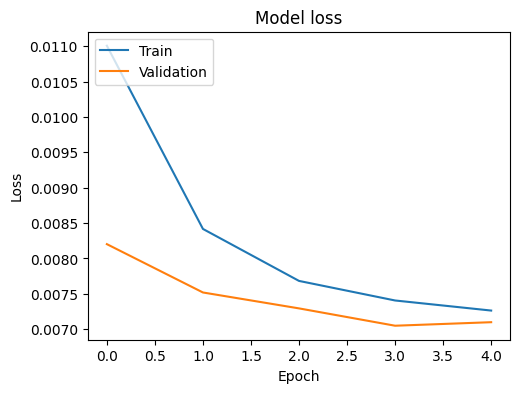

In [286]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

# plt.subplot(1, 2, 1)
# plt.plot(hist.history['accuracy'])
# plt.plot(hist.history['val_accuracy'])
# plt.title('Model accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [298]:
x_test = "i want to order two medium pizzas with sausage and black olives and two medium pizzas with pepperoni and extra cheese and three large pizzas with pepperoni and sausage"
x_test = clean_text(x_test)
x_test = lemma(x_test)
print(x_test)
x_test = input_tokinezer.texts_to_sequences([x_test])
x_test = pad_sequences(x_test,max_len, padding='post')

i want to order two medium pizza with sausage and black olive and two medium pizza with pepperoni and extra cheese and three large pizza with pepperoni and sausage


In [299]:
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=-1)

# Convert the predicted indices back to tags
pred_tags = [tags[idx] for idx in y_pred[0]]

# Print the original sentence and the tags
original_sentence = [input_tokinezer.index_word[idx] for idx in x_test[0] if idx != 0]
print("Original Sentence:", " ".join(original_sentence))
print("Predicted Tags:", pred_tags)

1/1 [==============================] - 0s 21ms/step
Original Sentence: two medium pizza with sausage and black olive and two medium pizza with pepperoni and extra cheese and three large pizza with pepperoni and sausage
Predicted Tags: ['B-NUMBER', 'B-SIZE', 'O', 'O', 'B-TOPPING', 'O', 'B-TOPPING', 'I-TOPPING', 'O', 'B-NUMBER', 'B-SIZE', 'O', 'O', 'B-TOPPING', 'O', 'B-QUANTITY', 'B-TOPPING', 'O', 'B-NUMBER', 'B-SIZE', 'O', 'O', 'B-TOPPING', 'O', 'B-TOPPING']


In [269]:
import progressbar
n_epochs = 10
n_classes = len(tags)

for i in range(n_epochs):
    print("Training epoch {}".format(i))
    
    bar = progressbar.ProgressBar(maxval=len(X_train))
    for n_batch, sent in bar(enumerate(X_train)):
        label = y_train[n_batch]
        # Make labels one hot
        label = np.eye(n_classes)[label][np.newaxis,:] 
        # View each sentence as a batch
        sent = sent[np.newaxis,:] 
        
        if sent.shape[1] > 1: #ignore 1 word sentences
            model.train_on_batch(sent, label)

Training epoch 0


ValueError: in user code:

    File "c:\Users\Yara\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1377, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\Yara\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1360, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Yara\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1349, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\Yara\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1127, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\Yara\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1185, in compute_loss
        return self.compiled_loss(
    File "c:\Users\Yara\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\compile_utils.py", line 277, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\Yara\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\losses.py", line 143, in __call__
        losses = call_fn(y_true, y_pred)
    File "c:\Users\Yara\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\losses.py", line 270, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\Yara\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\losses.py", line 2221, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "c:\Users\Yara\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\backend.py", line 5575, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (1, 25, 25) and (1, 21, 25) are incompatible


In [153]:
hidden_units = 128

In [154]:
input_layer = Input(shape=(max_len,))
embedding_layer = Embedding(len(input_tokinezer.word_index)+1, hidden_units, input_length=max_len)(input_layer)
lstm = LSTM(hidden_units, return_sequences=True)(embedding_layer)
lstm = LSTM(hidden_units, return_sequences=True)(lstm)
output_layer = Dense(len(tags), activation='softmax')(lstm)

In [155]:
model = Model(inputs = input_layer, outputs = output_layer)    
model.summary() 

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 24)]              0         
                                                                 
 embedding_7 (Embedding)     (None, 24, 128)           32896     
                                                                 
 lstm_11 (LSTM)              (None, 24, 128)           131584    
                                                                 
 lstm_12 (LSTM)              (None, 24, 128)           131584    
                                                                 
 dense_4 (Dense)             (None, 24, 25)            3225      
                                                                 
Total params: 299289 (1.14 MB)
Trainable params: 299289 (1.14 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [156]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [157]:
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=2)

Epoch 1/10
313/313 - 16s - loss: 0.7082 - accuracy: 0.8255 - 16s/epoch - 51ms/step
Epoch 2/10
313/313 - 11s - loss: 0.0499 - accuracy: 0.9868 - 11s/epoch - 37ms/step
Epoch 3/10
313/313 - 12s - loss: 0.0193 - accuracy: 0.9933 - 12s/epoch - 38ms/step
Epoch 4/10
313/313 - 14s - loss: 0.0138 - accuracy: 0.9942 - 14s/epoch - 44ms/step
Epoch 5/10
313/313 - 13s - loss: 0.0117 - accuracy: 0.9944 - 13s/epoch - 41ms/step
Epoch 6/10
313/313 - 12s - loss: 0.0109 - accuracy: 0.9944 - 12s/epoch - 40ms/step
Epoch 7/10
313/313 - 13s - loss: 0.0104 - accuracy: 0.9946 - 13s/epoch - 41ms/step
Epoch 8/10
313/313 - 13s - loss: 0.0099 - accuracy: 0.9948 - 13s/epoch - 40ms/step
Epoch 9/10
313/313 - 13s - loss: 0.0099 - accuracy: 0.9947 - 13s/epoch - 41ms/step
Epoch 10/10
313/313 - 13s - loss: 0.0097 - accuracy: 0.9948 - 13s/epoch - 42ms/step


In [168]:
X_test, y_test = generate_training_data(df_dev['dev.SRC'].apply(clean_text).apply(lemma))

In [169]:
X_test = input_tokinezer.texts_to_sequences(X_test)

In [170]:
y_test = [y.split() for y in y_test]
y_test = [[tags.index(tag) for tag in y] for y in y_test]

In [171]:
y_test = pad_sequences(y_test,max_len, padding='post')
X_test = pad_sequences(X_test,max_len, padding='post')

In [172]:
model.evaluate(X_test, y_test)

11/11 [==============================] - 0s 14ms/step - loss: 0.9353 - accuracy: 0.8487


[0.935344934463501, 0.8486589789390564]

In [ ]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)

# y_test = y_test.flatten()
# y_pred = y_pred.flatten()

print(y_test.shape, y_pred.shape)


# print(classification_report(y_test, y_pred))

In [199]:
input_text = "i want to order two medium pizzas with sausage and black olives and two medium pizzas with pepperoni and extra cheese and three large pizzas with pepperoni and sausage"
cleaned_text = clean_text(input_text)
print(cleaned_text)
lemmatized_text = lemma(cleaned_text)
print(lemmatized_text)
t_x, t_y = generate_training_data([lemmatized_text])

i want to order two medium pizzas with sausage and black olives and two medium pizzas with pepperoni and extra cheese and three large pizzas with pepperoni and sausage
i want to order two medium pizza with sausage and black olive and two medium pizza with pepperoni and extra cheese and three large pizza with pepperoni and sausage


In [200]:
max_len = max([len(x) for x in t_x])

In [201]:
t_x = input_tokinezer.texts_to_sequences(t_x)
t_x = pad_sequences(t_x,max_len, padding='post')
t_y = [y.split() for y in t_y]
t_y = [[tags.index(tag) for tag in y] for y in t_y]
t_y = pad_sequences(t_y,max_len, padding='post')

pred = model.predict(t_x)
pred = np.argmax(pred, axis=-1)


1/1 [==============================] - 0s 77ms/step


In [202]:
# Convert the predicted indices back to tags
pred_tags = [[tags[idx] for idx in sentence] for sentence in pred]
true_tags = [[tags[idx] for idx in sentence] for sentence in t_y]

# Print the original sentence and the tags
for i in range(len(t_x)):
    original_sentence = [input_tokinezer.index_word[idx] for idx in t_x[i] if idx != 0]
    print("Original Sentence:", " ".join(original_sentence))
    print("Predicted Tags:", pred_tags[i])
    print("True Tags     :", true_tags[i])
    print()

Original Sentence: i want <OOV> <OOV> two medium pizza with sausage and black olive and two medium pizza with pepperoni and extra cheese and three large pizza with pepperoni and sausage
Predicted Tags: ['O', 'O', 'B-NUMBER', 'B-TOPPING', 'B-NUMBER', 'B-SIZE', 'O', 'O', 'B-TOPPING', 'O', 'B-TOPPING', 'I-TOPPING', 'O', 'B-NUMBER', 'B-SIZE', 'O', 'O', 'B-TOPPING', 'O', 'B-QUANTITY', 'B-TOPPING', 'O', 'B-NUMBER', 'B-SIZE', 'O', 'O', 'B-TOPPING', 'O', 'B-TOPPING', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', '

In [179]:
# y_pred
df_dev['dev.INPUT'] = [[tags[idx] for idx in sentence] for sentence in y_pred]


In [34]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer

# Example tokenized input with corresponding labels
# tokens = ["balsamic", "glaze", "and", "a", "sprite", "and", "three", "eight", "ounce", "fantas", "and", "three", "sprite"]
# labels = ["B-TOPPING", "I-TOPPING", "O", "O", "B-DRINKTYPE", "O", "B-NUMBER", "B-VOLUME", "I-VOLUME", "B-DRINKTYPE", "O", "B-NUMBER", "B-DRINKTYPE"]

tokens = X_train[:2]
labels = y_train[:2]

# Extracting simple features for each token (you can add more sophisticated features)
features = []
for i in range(len(tokens)):
    t = tokens[i].split()
    for idx,word in enumerate(t):
        features.append({
            'word': word,
            'prev_word': t[idx-1] if idx > 0 else 'SOS',
            'next_word': t[idx+1] if idx < len(t)-1 else 'EOS',
            'is_digit': True if  (word.isdigit() or words_to_number(word)) else False,
        })
    

# Convert features to a feature matrix using DictVectorizer
vectorizer = DictVectorizer(sparse=False)
X = vectorizer.fit_transform(features)


In [36]:
print(X)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]


In [ ]:
# Train a decision tree classifier
clf = DecisionTreeClassifier()
clf.fit(X, labels)

# Predict the labels for the tokens
predictions = clf.predict(X)

# Post-process to structure the output (as per your desired format)
for token, label, prediction in zip(tokens, labels, predictions):
    print(f"Token: {token}, True Label: {label}, Predicted Label: {prediction}")

In [208]:
from tensorflow_addons.text import crf_log_likelihood, viterbi_decode
import tensorflow_addons as tfa


import tensorflow as tf
import tensorflow_addons as tfa

def crf_loss(y_true, y_pred):
    # Convert inputs to float32
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    # Reshape y_pred to 3D
    num_tags = len(extractor.tags)
    y_pred = tf.reshape(y_pred, [-1, y_true.shape[1], num_tags])
    
    # Compute sequence lengths
    sequence_lengths = tf.reduce_sum(tf.cast(tf.not_equal(y_true, 0), tf.int32), axis=1)
    
    # Compute log likelihood
    log_likelihood, _ = tfa.text.crf_log_likelihood(
        y_pred,
        tf.cast(y_true, tf.int32),
        sequence_lengths
    )
    
    return -tf.reduce_mean(log_likelihood)



def crf_accuracy(y_true, y_pred):
    sequence_lengths = tf.reduce_sum(tf.cast(tf.not_equal(y_true, 0), tf.int32), axis=1)
    viterbi_sequences, _ = tfa.text.viterbi_decode(y_pred, sequence_lengths)
    correct_predictions = tf.equal(tf.cast(y_true, tf.int32), tf.cast(viterbi_sequences, tf.int32))
    return tf.reduce_mean(tf.cast(correct_predictions, tf.float32))


In [209]:

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow_addons.layers import CRF
from tensorflow_addons.text.crf import crf_decode , crf_log_likelihood ,  viterbi_decode , crf_sequence_score

from tensorflow.keras import backend as K


class OrderExtractor:
    def __init__(self, max_length=100):
        self.max_length = max_length
        self.word_tokenizer = Tokenizer(lower=True, split=' ')
        
        # Define tags for NER
        self.tags = [
            'O',  # Outside
            'B-DRINKORDER', 'I-DRINKORDER',
            'B-PIZZAORDER', 'I-PIZZAORDER',
            'B-NUMBER', 'I-NUMBER',
            'B-DRINKTYPE', 'I-DRINKTYPE',
            'B-VOLUME', 'I-VOLUME',
            'B-TOPPING', 'I-TOPPING',
            'B-SIZE', 'I-SIZE',
            'B-QUANTITY', 'I-QUANTITY',
            'B-STYLE', 'I-STYLE',
            'B-CONTAINER', 'I-CONTAINER',
            'B-NOT-TOPPING', 'I-NOT-TOPPING',
            'B-NOT-STYLE' , 'I-NOT-STYLE'
        ]
        self.tag_to_index = {tag: idx for idx, tag in enumerate(self.tags)}
        self.index_to_tag = {idx: tag for tag, idx in self.tag_to_index.items()}
        
    def prepare_data(self, texts, labels):
        # Tokenize words
        self.word_tokenizer.fit_on_texts(texts)
        word_sequences = self.word_tokenizer.texts_to_sequences(texts)
        word_sequences = pad_sequences(word_sequences, maxlen=self.max_length, padding='post')
        
        # Prepare label sequences
        label_sequences = []
        for label_sequence in labels:
            label_sequence = label_sequence.split()
            label_sequence = [self.tag_to_index[label] for label in label_sequence]
            label_sequences.append(label_sequence)
            
        label_sequences = pad_sequences(label_sequences, maxlen=self.max_length, padding='post')
        
        return word_sequences, label_sequences
    
    def create_model(self, vocab_size, embedding_dim=100, lstm_units=128):
        # Input layer
        input_layer = Input(shape=(self.max_length,))
        
        # Embedding layer
        embedding = Embedding(
            input_dim=vocab_size, 
            output_dim=embedding_dim, 
            mask_zero=True
        )(input_layer)
        
        # BiLSTM layers with dropout
        bilstm = Bidirectional(LSTM(
            units=lstm_units, 
            return_sequences=True,
            recurrent_dropout=0.2
        ))(embedding)
        
        # Dense layer
        dense = Dense(len(self.tags))(bilstm)        
        # CRF layer
        crf = CRF(len(self.tags),)
        
        output = crf(dense)
        
        # Create model
        model = Model(inputs=input_layer, outputs=output)
        model.compile(
            optimizer='adam', 
            loss=crf_loss,
            metrics=[crf_accuracy]
        )
        
        return model
    
    def parse_prediction(self, tokens, prediction):
        def extract_entity(start, entity_type):
            entity_tokens = []
            for j in range(start, len(tokens)):
                if prediction[j] == self.tag_to_index[f'I-{entity_type}']:
                    entity_tokens.append(tokens[j])
                else:
                    break
            return ' '.join(entity_tokens)
        
        parsed_orders = []
        current_order = {}
        
        for i, tag_index in enumerate(prediction):
            tag = self.index_to_tag[tag_index]
            
            if tag.startswith('B-DRINKORDER') or tag.startswith('B-PIZZAORDER'):
                if current_order:
                    parsed_orders.append(current_order)
                current_order = {}
                current_order['type'] = tag.split('-')[1]
            
            if tag.startswith('B-NUMBER'):
                current_order['NUMBER'] = extract_entity(i, 'NUMBER')
            
            if tag.startswith('B-DRINKTYPE'):
                current_order['DRINKTYPE'] = extract_entity(i, 'DRINKTYPE')
            
            if tag.startswith('B-VOLUME'):
                current_order['VOLUME'] = extract_entity(i, 'VOLUME')
            
            if tag.startswith('B-TOPPING'):
                current_order['TOPPING'] = extract_entity(i, 'TOPPING')
        
        if current_order:
            parsed_orders.append(current_order)
        
        return parsed_orders
    
    def format_output(self, parsed_orders):
        output_str = "("
        for order in parsed_orders:
            order_type = order.get('type', '')
            output_str += f"{order_type} "
            
            if 'NUMBER' in order:
                output_str += f"(NUMBER {order['NUMBER']}) "
            
            if 'DRINKTYPE' in order:
                output_str += f"(DRINKTYPE {order['DRINKTYPE'].upper()}) "
            
            if 'VOLUME' in order:
                output_str += f"(VOLUME {order['VOLUME'].upper()}) "
            
            if 'TOPPING' in order:
                output_str += f"(TOPPING {order['TOPPING'].upper()}) "
        
        output_str += ")"
        return output_str


In [215]:

# Example usage
extractor = OrderExtractor()

# Prepare data
X_train_pre, y_train_pre = extractor.prepare_data(X_train, y_train)
y_train_pre_3d = tf.keras.utils.to_categorical(y_train_pre, num_classes=len(extractor.tags))
# Ensure labels are integer-encoded
y_train_pre_3d = y_train_pre_3d.astype(np.int32)
# Instead of to_categorical, keep labels as integer indices
y_train_pre_3d = y_train_pre  # Assuming y_train_pre is already integer-encoded

# Ensure labels are padded to max_length if needed
y_train_pre_3d = tf.keras.preprocessing.sequence.pad_sequences(
    y_train_pre_3d, 
    maxlen=extractor.max_length, 
    padding='post', 
    value=0  # Use 0 as padding value
)




In [216]:
# Create model
vocab_size = len(extractor.word_tokenizer.word_index) + 1
model = extractor.create_model(vocab_size)

# Train model
model.fit(X_train_pre, y_train_pre_3d, epochs=10, verbose=2, batch_size=32)

# Predict
test_text = "balsamic glaze and a sprite and three eight ounce fantas and three sprites"
test_seq = extractor.word_tokenizer.texts_to_sequences([test_text])
test_seq = pad_sequences(test_seq, maxlen=extractor.max_length, padding='post')

prediction = model.predict(test_seq)[0]
predicted_tags = np.argmax(prediction, axis=-1)

# Parse and format output
parsed_orders = extractor.parse_prediction(test_text.split(), predicted_tags)
output = extractor.format_output(parsed_orders)
print(output)

Epoch 1/10


ValueError: in user code:

    File "c:\Users\Yara\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1377, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\Yara\AppData\Local\Temp\ipykernel_22988\4180131057.py", line 15, in crf_loss  *
        y_pred = tf.reshape(y_pred, [-1, y_true.shape[1], num_tags])

    ValueError: Dimension size must be evenly divisible by 2500 but is 625 for '{{node crf_loss_3/Reshape}} = Reshape[T=DT_FLOAT, Tshape=DT_INT32](crf_loss_3/Reshape/ReadVariableOp, crf_loss_3/Reshape/shape)' with input shapes: [25,25], [3] and with input tensors computed as partial shapes: input[1] = [?,100,25].


In [24]:
def extract_features(sentence):
    """Extract features for each word in the sentence, considering context."""
    features = []
    for i, word in enumerate(sentence):
        word_features = {
            "word": word,
            "is_digit": word.isdigit() or words_to_number(word) is not None,
            # "is_title": word.istitle(),
            "suffix": word[-3:],  # Last 3 characters
            "prefix": word[:3],  # First 3 characters
        }
        # Add previous word features
        if i > 0:
            word_features["prev_word"] = sentence[i - 1]
            word_features["prev_is_digit"] = sentence[i - 1].isdigit()
        else:
            word_features["prev_word"] = "<SOS>"
            word_features["prev_is_digit"] = False
        
        # Add next word features
        if i < len(sentence) - 1:
            word_features["next_word"] = sentence[i + 1]
            word_features["next_is_digit"] = sentence[i + 1].isdigit() or words_to_number(sentence[i + 1]) is not None
        else:
            word_features["next_word"] = "<EOS>"
            word_features["next_is_digit"] = False
        
        features.append(word_features)
    return features


In [27]:
# Example usage
sentence = ["I'd", "like", "three", "large", "pies", "with", "pesto"]
features = extract_features(sentence)
for word_feature in features:
    print(word_feature)

{'word': "I'd", 'is_digit': False, 'suffix': "I'd", 'prefix': "I'd", 'prev_word': '<SOS>', 'prev_is_digit': False, 'next_word': 'like', 'next_is_digit': False}
{'word': 'like', 'is_digit': False, 'suffix': 'ike', 'prefix': 'lik', 'prev_word': "I'd", 'prev_is_digit': False, 'next_word': 'three', 'next_is_digit': True}
{'word': 'three', 'is_digit': True, 'suffix': 'ree', 'prefix': 'thr', 'prev_word': 'like', 'prev_is_digit': False, 'next_word': 'large', 'next_is_digit': False}
{'word': 'large', 'is_digit': False, 'suffix': 'rge', 'prefix': 'lar', 'prev_word': 'three', 'prev_is_digit': False, 'next_word': 'pies', 'next_is_digit': False}
{'word': 'pies', 'is_digit': False, 'suffix': 'ies', 'prefix': 'pie', 'prev_word': 'large', 'prev_is_digit': False, 'next_word': 'with', 'next_is_digit': False}
{'word': 'with', 'is_digit': False, 'suffix': 'ith', 'prefix': 'wit', 'prev_word': 'pies', 'prev_is_digit': False, 'next_word': 'pesto', 'next_is_digit': False}
{'word': 'pesto', 'is_digit': False,

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Bidirectional, Dense, Concatenate, Dropout
import tensorflow_addons as tfa

# Define parameters
vocab_size = 5000  # Vocabulary size
pos_vocab_size = 50  # POS tags vocabulary size
tag_size = 10  # Number of output tags
embedding_dim = 100
pos_embedding_dim = 16
hidden_dim = 128
max_len = 50  # Maximum sentence length

# Word input and embedding
word_input = Input(shape=(max_len,), dtype='int32', name='word_input')
word_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, mask_zero=True, name='word_embedding')(word_input)

# POS input and embedding (optional contextual feature)
pos_input = Input(shape=(max_len,), dtype='int32', name='pos_input')
pos_embedding = Embedding(input_dim=pos_vocab_size, output_dim=pos_embedding_dim, mask_zero=True, name='pos_embedding')(pos_input)

# Combine word and POS embeddings
combined_embedding = Concatenate(name='combined_embedding')([word_embedding, pos_embedding])

# BiLSTM layer
bilstm = Bidirectional(LSTM(hidden_dim // 2, return_sequences=True, dropout=0.1, recurrent_dropout=0.1), name='bilstm')(combined_embedding)

# Dense layer to project LSTM output to tag space
dense = Dense(tag_size, activation=None, name='dense')(bilstm)

# CRF layer
crf = tfa.layers.CRF(tag_size, name='crf')
output = crf(dense)

# Define the model
model = Model(inputs=[word_input, pos_input], outputs=output)

# Compile the model with CRF loss and accuracy
model.compile(optimizer='adam', loss=crf.loss, metrics=[crf.metrics])
model.summary()


In [ ]:
from sklearn_crfsuite import CRF

# Define training data
X_train = [extract_features(sentence) for sentence in training_sentences]  # List of feature dictionaries
y_train = training_labels  # Corresponding labels

# Train CRF
crf = CRF(algorithm='lbfgs', max_iterations=100)
crf.fit(X_train, y_train)


In [ ]:
from sklearn_crfsuite import CRF

# Define features
def extract_features(sentence):
    return [
        {
            'word': word,
            'is_digit': word.isdigit(),
            'is_title': word.istitle(),
            'suffix': word[-3:],
        }
        for word in sentence
    ]

# Train a CRF model (pseudo-code; requires labeled dataset)
crf = CRF(algorithm='lbfgs', max_iterations=100)
crf.fit(X_train, train_y)  # `X_train` and `train_y` are tokenized sentences and labels

# Predict on input text
sentence = "I'd like three large pies with pestos and yellow peppers".split()
features = extract_features(sentence)
labels = crf.predict_single(features)

# Map labels to the desired output
def format_output(sentence, labels):
    output = "(ORDER (PIZZAORDER "
    for word, label in zip(sentence, labels):
        if label == "B-NUMBER":
            output += f"(NUMBER {word} ) "
        elif label == "B-SIZE":
            output += f"(SIZE {word.upper()} ) "
        elif label.startswith("B-TOPPING"):
            output += f"(TOPPING {word.replace(' ', '_').upper()} ) "
    output += "))"
    return output

output = format_output(sentence, labels)
print(output)
